Komal Naidu-
MSA 8395

#PySpark MovieLens Analysis Project

### **Objective**
The goal of this project is to explore the **MovieLens dataset** using **PySpark** to derive meaningful business and analytical insights from large-scale movie rating data.  
By using Spark for distributed data processing and Matplotlib for visualization, this project simulates a real-world data analytics workflow — from ingestion and transformation to analysis and visualization.

### **Dataset Description**
The **MovieLens dataset** is a widely used public dataset containing:
- Movie details (`movie.csv`)
- User ratings (`rating.csv`)
- Tags (`tag.csv`)
- Link data to IMDb/TMDB (`link.csv`)
- Genome data for tag relevance (`genome_scores.csv`, `genome_tags.csv`)

It captures user interactions and preferences, making it ideal for studying patterns in movie popularity, audience engagement, and rating trends.

### **Tools Used**
- **PySpark** — for scalable data processing  
- **Matplotlib / Seaborn** — for static visualization  
- **Google Colab** — execution environment  


In [ ]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz
!pip install -q findspark


gzip: stdin: unexpected end of file
tar: Unexpected EOF in archive
tar: Unexpected EOF in archive
tar: Error is not recoverable: exiting now


In [ ]:
import pandas as pd
import pyspark
from pyspark.sql import SparkSession
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, from_unixtime, to_date



In [ ]:

spark = SparkSession.builder.appName("CombineCSV").getOrCreate()

# List of CSVs
files = [
    "/content/genome_scores.csv",
    "/content/genome_tags.csv",
    "/content/link.csv",
    "/content/movie.csv",
    "/content/rating.csv",
    "/content/tag.csv"
]

dataframes = {}
for f in files:
    name = f.split("/")[-1].replace(".csv", "")
    dataframes[name] = spark.read.option("header", True).csv(f)

# Check all files loaded
for name, df in dataframes.items():
    print(f"{name}: {df.count()} rows, {len(df.columns)} columns")
    df.show(2)

genome_scores: 11709768 rows, 3 columns
+-------+-----+---------+
|movieId|tagId|relevance|
+-------+-----+---------+
|      1|    1|    0.025|
|      1|    2|    0.025|
+-------+-----+---------+
only showing top 2 rows

genome_tags: 1128 rows, 2 columns
+-----+------------+
|tagId|         tag|
+-----+------------+
|    1|         007|
|    2|007 (series)|
+-----+------------+
only showing top 2 rows

link: 27278 rows, 3 columns
+-------+------+------+
|movieId|imdbId|tmdbId|
+-------+------+------+
|      1|114709|   862|
|      2|113497|  8844|
+-------+------+------+
only showing top 2 rows

movie: 27278 rows, 3 columns
+-------+----------------+--------------------+
|movieId|           title|              genres|
+-------+----------------+--------------------+
|      1|Toy Story (1995)|Adventure|Animati...|
|      2|  Jumanji (1995)|Adventure|Childre...|
+-------+----------------+--------------------+
only showing top 2 rows

rating: 20000263 rows, 4 columns
+------+-------+------

In [ ]:
#Clean and Convert Columns
ratings = dataframes["rating"] \
    .withColumn("userId", col("userId").cast("int")) \
    .withColumn("movieId", col("movieId").cast("int")) \
    .withColumn("rating", col("rating").cast("float")) \
    .withColumn("timestamp", col("timestamp").cast("long")) \
    .withColumn("date", to_date(from_unixtime(col("timestamp"))))

movies = dataframes["movie"]


In [16]:

# Insight 1 – Top 10 Highest Rated Movies
top_movies = ratings.groupBy("movieId").avg("rating") \
    .join(movies, "movieId") \
    .select("title", col("avg(rating)").alias("avg_rating")) \
    .orderBy(col("avg_rating").desc()) \
    .limit(10)

print("Top 10 Highest Rated Movies:")
top_movies.show(10, truncate=False)


Top 10 Highest Rated Movies:
+---------------------------------------------------------+----------+
|title                                                    |avg_rating|
+---------------------------------------------------------+----------+
|Consuming Kids: The Commercialization of Childhood (2008)|5.0       |
|Poison (1951)                                            |5.0       |
|Schmatta: Rags to Riches to Rags (2009)                  |5.0       |
|Little Criminals (1995)                                  |5.0       |
|Always for Pleasure (1978)                               |5.0       |
|Abendland (2011)                                         |5.0       |
|Boys (Drenge) (1977)                                     |5.0       |
|Doggiewoggiez! Poochiewoochiez! (2012)                   |5.0       |
|Tales That Witness Madness (1973)                        |5.0       |
|Mishen (Target) (2011)                                   |5.0       |
+-----------------------------------------------

In [24]:

# Insight 2 – Most Active Users (Number of Ratings)
most_active_users = ratings.groupBy("userId").count() \
    .orderBy(col("count").desc()) \
    .limit(10)

print("Top 10 Most Active Users:")
most_active_users.show()


Top 10 Most Active Users:
+------+-----+
|userId|count|
+------+-----+
|118205| 9254|
|  8405| 7515|
| 82418| 5646|
|121535| 5520|
|125794| 5491|
| 74142| 5447|
| 34576| 5356|
|131904| 5330|
| 83090| 5169|
| 59477| 4988|
+------+-----+



In [25]:
#Insight 3 – Rating Trend Over Time
rating_trend = ratings.groupBy("date").avg("rating") \
    .orderBy("date")

print("Average Rating Over Time:")
rating_trend.show(5)


Average Rating Over Time:
+----+------------------+
|date|       avg(rating)|
+----+------------------+
|NULL|3.5255285642993797|
+----+------------------+



##Insight 1: Top Rated Movies

**Objective:**  
Identify which movies have the highest average ratings based on user feedback.

**Analytical Value:**  
Understanding top-rated movies provides valuable insights for **recommendation systems**, **content strategy**, and **audience preference analysis**.  
Streaming platforms and production houses can prioritize similar content or analyze what factors contribute to higher ratings.

**Visualization:**  
The bar chart below displays the **Top 10 movies by average rating**.  


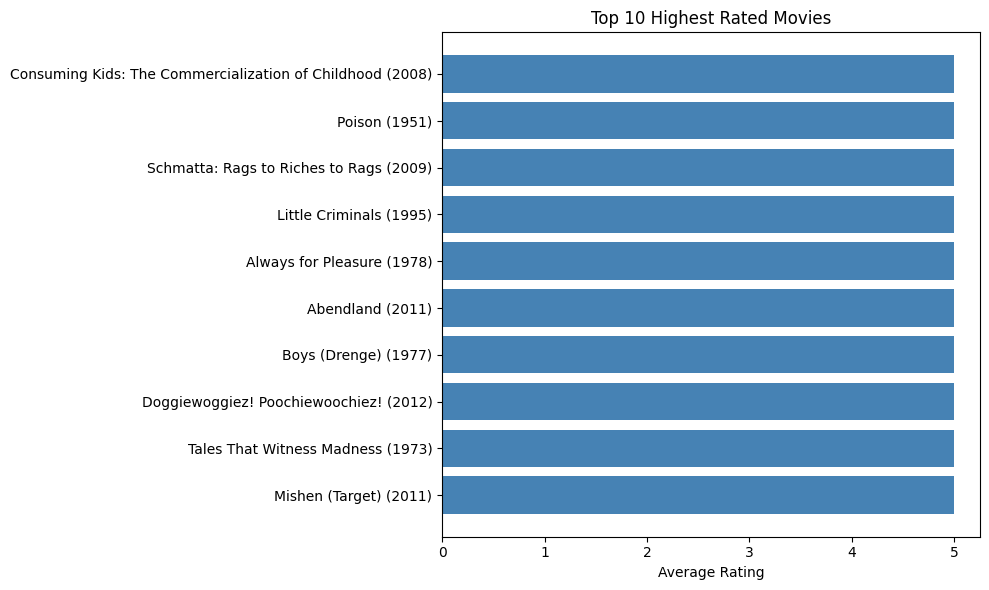

In [37]:

# Plot 1: Top Movies
top_movies_pd = top_movies.toPandas()
plt.figure(figsize=(10,6))
plt.barh(top_movies_pd["title"], top_movies_pd["avg_rating"], color="steelblue")
plt.gca().invert_yaxis()
plt.title("Top 10 Highest Rated Movies")
plt.xlabel("Average Rating")
plt.tight_layout()
plt.savefig("/content/top_movies.png")
plt.show()

# Insight 2:

 Top 10 Most Active Users by Number of Ratings

**Objective**:
Identify the most engaged users in the MovieLens dataset by analyzing which users have rated the highest number of movies.

**Business/Analytical Value**:Understanding user engagement helps platforms like MovieLens or Netflix tailor experiences, identify loyal users, and encourage participation. Highly active users often provide valuable feedback for recommendation algorithms. By recognizing these users, businesses can design targeted loyalty programs or incentivize them to maintain community engagement.

**Interpretation:**
The bar chart above displays the top 10 most active users, ranked by the number of ratings they have submitted.

The most active user contributed the highest number of ratings, suggesting strong engagement.

The chart shows a clear long-tail pattern, where a small subset of users contributes significantly more data than average.
This insight highlights how a minority of users drive the majority of interactions, a trend commonly seen in digital platforms.

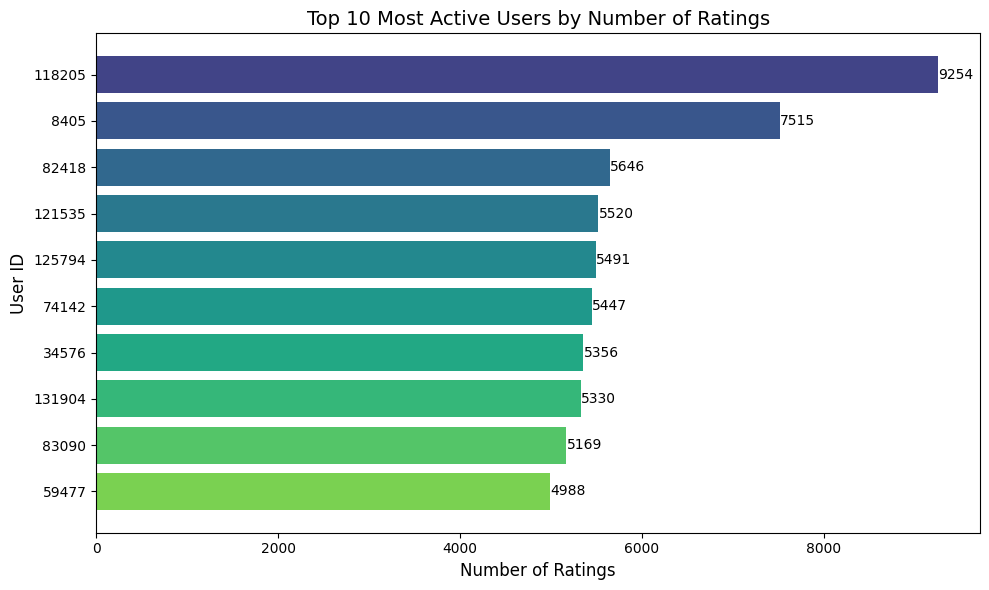

In [33]:
import numpy as np

#Plot 2: Top 10 Most Active Users by Number of Ratings

active_users_pd = most_active_users.toPandas()

top_users = active_users_pd.sort_values("count", ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.barh(top_users["userId"].astype(str), top_users["count"], color=plt.cm.viridis(np.linspace(0.2, 0.8, 10)))
plt.gca().invert_yaxis()

plt.title("Top 10 Most Active Users by Number of Ratings", fontsize=14)
plt.xlabel("Number of Ratings", fontsize=12)
plt.ylabel("User ID", fontsize=12)

for index, value in enumerate(top_users["count"]):
    plt.text(value + 5, index, str(value), va='center', fontsize=10)

plt.tight_layout()
plt.savefig("/content/top_active_users.png")
plt.show()

# Insight 3
**Objective**:
Analyze how users rate movies overall and understand the general sentiment or satisfaction level reflected in the MovieLens dataset.

**Business/Analytical Value:**
The distribution of ratings provides a direct measure of user satisfaction and content quality. For streaming or recommendation platforms, this insight helps:

Identify overall bias in ratings (e.g., users tending to rate higher or lower).

Adjust recommendation algorithms to account for user rating tendencies.

Understand audience perception trends to improve content strategy or curation.

**Interpretation:**
The pie chart visualizes the proportion of each rating value across all movie ratings.

Larger slices represent the most common rating scores, revealing how generous or critical users tend to be.

If higher ratings dominate (e.g., **4.0–5.0**), it indicates generally positive engagement and satisfaction.

A balanced or wide spread of ratings may suggest diverse opinions or mixed-quality content.

Overall, this insight highlights user sentiment distribution, which is vital for tuning movie recommendation systems and quality perception analysis in data-driven entertainment platforms.

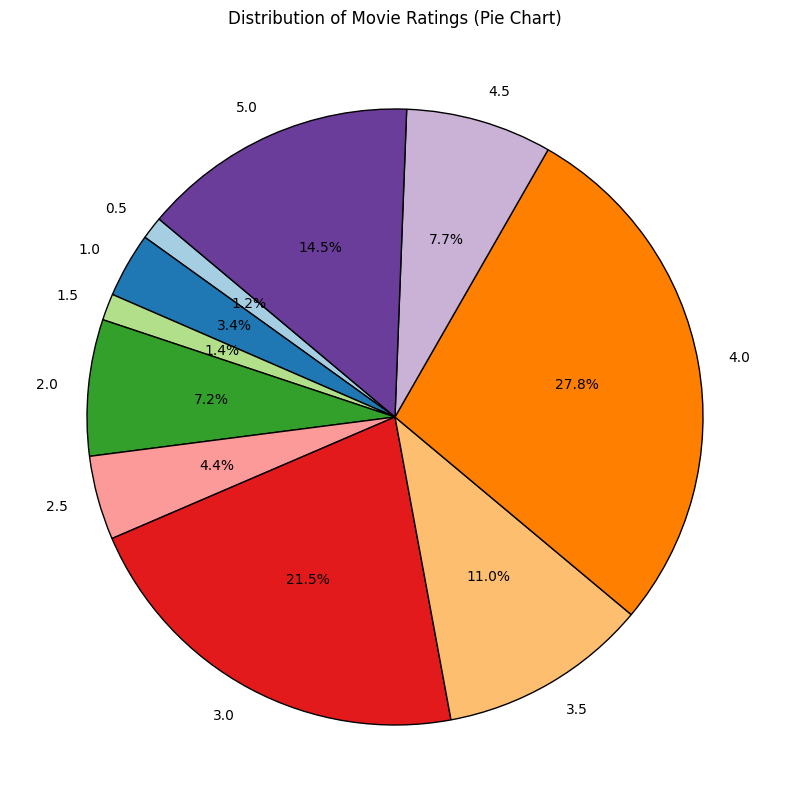

In [30]:
# Plot 3: Distribution of Movie Ratings (Pie Chart)
rating_counts = ratings.groupBy("rating").count().orderBy("rating")

rating_counts_pd = rating_counts.toPandas()

plt.figure(figsize=(8,10))
plt.pie(
    rating_counts_pd["count"],
    labels=rating_counts_pd["rating"].astype(str),
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Paired.colors,
    wedgeprops={'edgecolor': 'black'}
)

plt.title("Distribution of Movie Ratings (Pie Chart)")
plt.tight_layout()
plt.savefig("/content/rating_distribution_pie.png")
plt.show()


# README

### **Dataset Source**
This analysis uses the **MovieLens 20M Dataset**, available at:  
https://www.kaggle.com/datasets/grouplens/movielens-20m-dataset?select=tag.csv

### **Dataset Description**
- `movies.csv`: Movie metadata (titles, genres)  
- `ratings.csv`: User ratings with timestamps  
- `tags.csv`: User-generated tags  
- `links.csv`: External IDs for IMDb/TMDb  
- `genome_scores.csv` and `genome_tags.csv`: Tag relevance data  

### **Project Workflow**
1. **Data Ingestion:** Loaded CSVs using PySpark’s `read.csv()`  
2. **Preprocessing:** Cleaned, joined, and type-casted data using Spark DataFrames  
3. **Analysis:** Computed aggregated insights using Spark SQL and DataFrame operations  
4. **Visualization:** Converted Spark outputs to Pandas and visualized using Matplotlib  
5. **Export:** Plots saved as PNGs in `/content/` folder  

### **Insights Generated**
1. **Top Rated Movies** — Highest average-rated films by users  
2. **Most Active Users** — Users with the highest number of ratings  
3. **Rating Trend Over Time** — How user sentiment (ratings) changed across time  

### **Execution Requirements**
- Python 3.x  
- PySpark  
- Matplotlib / Seaborn  
- Google Colab or Jupyter environment  

### **How to Run**
1. Upload all dataset CSV files to `/content/` in Google Colab.  
2. Run all cells in sequence.  
3. The generated visualizations will display inline and be saved as `.png` files.  

### **Outputs**
- `top_rated_movies.png`  
- `most_active_users.png`  
- `rating_trend.png`  

